In [1]:
from langgraph.graph import StateGraph, END, MessagesState

class State(MessagesState):
    next_agent: str = ""
    research_data: str = ""
    analysis_data: str = ""
    blog: str = ""
    task: str = ""
    tone: str = ""
    length: str = ""
    audience: str = ""
    task_complete: bool = False

In [2]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="./config/.env")

True

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.1-8b-instant")

In [4]:
from langchain_core.messages import HumanMessage, AIMessage
from typing import Dict

def supervisor_agent(state: State) -> Dict:

    if not state.get("task"):
        task = state["messages"][-1].content
    else:
        task = state["task"]

    has_research = bool(state.get("research_data"))
    has_analysis = bool(state.get("analysis_data"))
    has_blog = bool(state.get("blog"))

    if not has_research:
        next_agent = "researcher"
        supervisor_msg = "📋 Starting research..."
    elif not has_analysis:
        next_agent = "analyst"
        supervisor_msg = "📊 Starting analysis..."
    elif not has_blog:
        next_agent = "writer"
        supervisor_msg = "✍️ Starting writing..."
    else:
        next_agent = "end"
        supervisor_msg = "🟢 Blog complete!"
    
    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "task": task,
        "task_complete": (next_agent == "end")
    }

In [ ]:
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

@tool
def search_tool(query: str) -> str:
    """Search the web for information."""
    search = TavilySearch(max_results=3)
    results = search.invoke(query)
    return str(results)

researcher_llm = llm.bind_tools([search_tool])

In [6]:
def researcher_agent(state: State) -> Dict:

    task = state.get("task", "")

    research_prompt = f"""As a research specialist, provide comprehensive using search_tool information about: {task}

    Include:
    1. Key facts and background
    2. Current trends or developments
    3. Important statistics or data points
    4. Notable examples or case studies
    
    Be concise but thorough."""

    response = researcher_llm.invoke([HumanMessage(content=research_prompt)])

    if "tool_calls" in response.additional_kwargs and response.additional_kwargs["tool_calls"]:
        tool_call = response.additional_kwargs["tool_calls"][0]

        args = tool_call["function"]["arguments"]

        tool_result = search_tool.invoke(args)

        followup = llm.invoke([
            HumanMessage(content=f"Here are the tool results:\n{tool_result}\n\nSummarize them into a clean research summary.")
        ])

        research_text = followup.content.strip()
    else:
        research_text = response.content.strip()


    return {
        "messages": [AIMessage(content="🔍 Research completed.")],
        "research_data": research_text,
        "next_agent": "supervisor"
    }

In [7]:
def analyst_agent(state: State) -> Dict:

    research_data = state.get("research_data", "")
    task = state.get("task", "")

    analysis_prompt = f"""As a data analyst, analyze this research data and provide insights:

    Research Data:
    {research_data}

    Provide:
    1. Key insights and patterns
    2. Strategic implications
    3. Risks and opportunities
    4. Recommendations

    Focus on actionable insights related to: {task}"""

    analysis_response = llm.invoke([HumanMessage(content=analysis_prompt)])
    analysis = analysis_response.content

    return {
        "messages": [AIMessage(content="📊 Analysis completed.")],
        "analysis_data": analysis,
        "next_agent": "supervisor"
    }

In [8]:
def writer_agent(state: State) -> Dict:
    task = state.get("task", "")
    research_data = state.get("research_data", "")
    analysis_data = state.get("analysis_data", "")
    tone = state.get("tone", "professional")
    length = state.get("length", "medium")
    audience = state.get("audience", "general readers")

    writing_prompt = f"""
    You are a professional blog writer.

    Your task: Create a polished, engaging, well-structured blog based on the topic, 
    research, analysis, and filters below.

    --- USER FILTERS ---
    Tone: {tone}
    Length: {length}
    Target Audience: {audience}

    --- DATA ---
    Blog Topic: {task}

    Research Summary:
    {research_data[:1500]}

    Analyst Insights:
    {analysis_data[:1500]}

    --- STRICT OUTPUT FORMAT ---
    You MUST return the blog ONLY in this exact structure:

    **TITLE** 
    Write one compelling, SEO-friendly title. Bold using Markdown (**Title**).

    **Introduction**  
    Write exactly ONE paragraph of EXACTLY 5 lines.  
    Each line must be separated using a manual line break.  
    Each line must be a complete sentence.  
    NO extra lines.

    **Main Section**  
    Write 2 or 3 paragraphs.  
    Each paragraph must contain EXACTLY 6-7 lines.  
    Each line must be separated using a manual line break.  
    Paragraphs must be separated by one blank line.

    **Conclusion**  
    Write ONE paragraph of EXACTLY 3-4 lines.  
    Each line must be separated with a manual line break.

    --- RULES ---
    - Adapt tone based on user choice.
    - Adjust writing style to suit the target audience.
    - Expand or compress content depending on length setting (short, medium, long).
    - Use research data for accuracy.
    - Use analyst insights for clarity and interpretation.
    - No extra headings.
    - No bullets.
    - Do NOT exceed line limits.
    """

    blog_response = llm.invoke([HumanMessage(content=writing_prompt)])
    blog = blog_response.content

    final_blog = f"""
📝 BLOG ARTICLE

{'='*60}

{blog}

{'='*60}
Blog generated by Multi-Agent AI System powered by Groq
{'='*60}
"""

    return {
        "messages": [AIMessage(content="✍️ Blog writing complete.")],
        "blog": final_blog,
        "next_agent": "supervisor",
        "task_complete": True
    }


In [9]:
from typing import Literal

def router(state: State) -> Literal["supervisor", "researcher", "analyst", "writer", "__end__"]:
    next_agent = state.get("next_agent", "supervisor")

    if state.get("task_complete"):
        return END

    return next_agent

In [10]:
workflow = StateGraph(State)

In [11]:
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("researcher", researcher_agent)
workflow.add_node("analyst", analyst_agent)
workflow.add_node("writer", writer_agent)


In [12]:
workflow.set_entry_point("supervisor")

In [13]:
workflow.add_conditional_edges(
    "supervisor",
    router,
    {
        "researcher": "researcher",
        "analyst": "analyst",
        "writer": "writer",
        END: END
    }
)

workflow.add_edge("researcher", "supervisor")
workflow.add_edge("analyst", "supervisor")
workflow.add_edge("writer", "supervisor")

graph=workflow.compile()
    

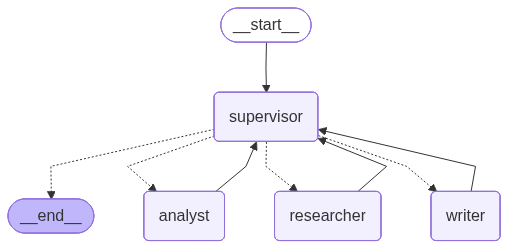

In [14]:
graph

In [15]:
events = []

for event in graph.stream(
    {
        "messages": [HumanMessage(content="Future of AI in healthcare")],
        "tone": "informative",
        "length": "medium",
        "audience": "general public"
    },
    stream_mode="updates"
):
    events.append(event)
    print(event)

{'supervisor': {'messages': [AIMessage(content='📋 Starting research...', additional_kwargs={}, response_metadata={}, id='6ecda744-e3dd-468d-85b8-a9b4510593de')], 'next_agent': 'researcher', 'task': 'Future of AI in healthcare', 'task_complete': False}}
{'researcher': {'messages': [AIMessage(content='🔍 Research completed.', additional_kwargs={}, response_metadata={}, id='fb28284c-2137-4a42-9fb9-fa903c04ba23')], 'research_data': '**Research Summary: "Future of AI in Healthcare"**\n\nThe search results provided do not directly relate to the topic of "Future of AI in Healthcare." Instead, they include three unrelated articles:\n\n1. **Book Query Result**: A TikTok video from an aspiring author (@katieanndenis) sharing their experience of submitting book queries and receiving responses while on a road trip. This result is unrelated to the topic of AI in healthcare.\n2. **NFL Scores**: A website (Pro-Football-Reference.com) providing the latest NFL scores and statistics. This result is unrel

In [16]:
from IPython.display import Markdown, display

display(Markdown(events[-2]["writer"]["blog"]))


📝 BLOG ARTICLE

============================================================

**The Future of AI in Healthcare: Trends, Opportunities, and Challenges**

The integration of artificial intelligence (AI) in healthcare is transforming the way medical professionals diagnose, treat, and prevent diseases. This technological advancement is expected to revolutionize the healthcare industry, improving patient outcomes and enhancing the overall quality of care. As AI continues to evolve, it is crucial to understand its future prospects in healthcare. By exploring the latest trends, opportunities, and challenges, we can unlock the full potential of AI in healthcare. With its vast capabilities, AI is poised to revolutionize the healthcare landscape.

The future of AI in healthcare is marked by several key trends. One of the most significant is the use of machine learning algorithms to analyze vast amounts of medical data, enabling healthcare professionals to identify patterns and make more accurate diagnoses. Additionally, AI-powered chatbots are being integrated into healthcare systems, providing patients with timely and personalized support. Furthermore, AI-assisted imaging is improving diagnostic accuracy, while also reducing the need for invasive procedures. Moreover, AI-powered robots are being used in surgeries, allowing for more precise and minimally invasive procedures. This trend towards automation is expected to continue, with AI playing a more prominent role in healthcare decision-making. As AI technology advances, it will be essential to address the challenges associated with its implementation.

The integration of AI in healthcare also presents several opportunities. For instance, AI can help healthcare professionals identify high-risk patients, enabling early interventions and improving outcomes. Additionally, AI-powered predictive analytics can help hospitals and healthcare systems anticipate and prepare for patient surges, reducing the likelihood of medical errors. Moreover, AI can help improve patient engagement, enabling individuals to take a more active role in their healthcare. Furthermore, AI can help reduce healthcare costs, by streamlining administrative tasks and reducing the need for unnecessary tests and procedures. By leveraging these opportunities, healthcare systems can improve patient care, reduce costs, and enhance the overall quality of care. As AI continues to evolve, it is essential to develop strategies for its effective implementation.

The use of AI in healthcare also raises several challenges. One of the most significant is the need for data standardization, which is essential for AI algorithms to function effectively. Moreover, there is a need for greater transparency and accountability in AI decision-making, to ensure that patients are treated fairly and without bias. Additionally, there is a need for healthcare professionals to receive training on AI technology, to ensure that they can effectively integrate it into their practice. Furthermore, there is a need for regulatory frameworks that address the use of AI in healthcare, to ensure that patients' rights are protected. By addressing these challenges, healthcare systems can ensure that AI is used in a safe, effective, and responsible manner.

The future of AI in healthcare is bright, with vast opportunities for improvement and innovation. By understanding the latest trends, opportunities, and challenges, we can unlock the full potential of AI in healthcare. As AI continues to evolve, it is essential to develop strategies for its effective implementation, ensuring that patients receive the best possible care. With its vast capabilities, AI is poised to revolutionize the healthcare landscape, improving patient outcomes and enhancing the overall quality of care.

============================================================
Blog generated by Multi-Agent AI System powered by Groq
============================================================


In [17]:
events = []

for event in graph.stream(
    {
        "messages": [HumanMessage(content="Generative AI in radiology")],
        "tone": "formal",
        "length": "long",
        "audience": "medical professionals"
    },
    stream_mode="updates"
):
    events.append(event)
    print(event)

{'supervisor': {'messages': [AIMessage(content='📋 Starting research...', additional_kwargs={}, response_metadata={}, id='60e0f96c-c86d-4841-861a-acc828761279')], 'next_agent': 'researcher', 'task': 'Generative AI in radiology', 'task_complete': False}}
{'researcher': {'messages': [AIMessage(content='🔍 Research completed.', additional_kwargs={}, response_metadata={}, id='bc3e64fa-8c8d-405d-8bb6-e997e5f0462d')], 'research_data': '**Key Facts and Trends in Generative AI in Radiology:**\n\nThe search results provided do not directly address the topic of generative AI in radiology. However, they can be summarized as follows:\n\n* There is no specific information available on the current trends, statistics, and examples of generative AI in radiology from the provided search results.\n\nHowever, some general insights can be derived from the search results:\n\n* **Understanding Search Results:** The first result from YouTube explains how search results may differ from user to user due to vario

In [18]:
from IPython.display import Markdown, display

display(Markdown(events[-2]["writer"]["blog"]))


📝 BLOG ARTICLE

============================================================

**The Future of Radiology: Unlocking the Potential of Generative AI**

The integration of artificial intelligence (AI) in radiology has been a topic of growing interest in recent years, with many researchers and medical professionals exploring its potential to improve diagnosis accuracy and patient outcomes. As we navigate the complexities of AI in radiology, one area that holds significant promise is generative AI. This technology has the power to revolutionize the way we approach medical imaging, but its applications and benefits are still shrouded in mystery. To uncover the truth, we need to delve deeper into the world of generative AI in radiology.

**Main Section**

Generative AI in radiology refers to the use of AI algorithms that can generate new medical images or enhance existing ones. These algorithms can learn from large datasets of medical images, allowing them to identify patterns and abnormalities that may not be visible to the human eye. This technology has the potential to improve diagnostic accuracy, reduce errors, and enhance patient care. However, the current landscape of generative AI in radiology is still in its infancy, with limited research and data available on its applications and benefits.

Despite the lack of specific information on generative AI in radiology, there are some general trends and insights that can be derived from existing research. For instance, the use of AI in radiology has been shown to improve diagnostic accuracy and reduce errors, particularly in areas such as breast cancer detection and lung nodule detection. Additionally, AI-powered imaging analysis has been shown to improve patient outcomes and reduce healthcare costs. To unlock the full potential of generative AI in radiology, researchers and medical professionals need to invest in more research and development.

However, there are also several challenges that need to be addressed before generative AI in radiology can become a reality. One of the main challenges is the lack of standardization and regulation in the field of AI in radiology. Without clear guidelines and regulations, it can be difficult to ensure the accuracy and safety of AI-generated images. Another challenge is the need for more data and research on the applications and benefits of generative AI in radiology. This will require collaboration between researchers, medical professionals, and industry experts to develop more effective and efficient AI algorithms.

In addition to these challenges, there are also several opportunities for generative AI in radiology to make a meaningful impact on patient care. For instance, AI-powered imaging analysis can help to improve diagnosis accuracy and reduce errors, particularly in areas such as cancer detection and patient monitoring. Additionally, AI-generated images can help to improve patient outcomes and reduce healthcare costs by providing more accurate and detailed images for diagnosis and treatment planning.

**Conclusion**

In conclusion, generative AI in radiology holds significant promise for improving diagnosis accuracy and patient outcomes. However, the current landscape of this technology is still in its infancy, with limited research and data available on its applications and benefits. To unlock the full potential of generative AI in radiology, researchers and medical professionals need to invest in more research and development, address the challenges of standardization and regulation, and explore the opportunities for AI-powered imaging analysis to make a meaningful impact on patient care. By working together, we can harness the power of generative AI in radiology to revolutionize the way we approach medical imaging and improve patient outcomes.

============================================================
Blog generated by Multi-Agent AI System powered by Groq
============================================================
